# Lorenz System

Example created by Wilson Rocha

Note: This example is based on the Lorenz system simulation reference from [UF|Physics: Introduction to Biological Physics](https://cmp.phys.ufl.edu/PHZ4710/files/unit5/Lorenz-system.html). Some of the code used for the Lorenz simulations and the bifurcation diagram is adapted from this resource.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint

from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function import Polynomial
from sysidentpy.utils.plotting import plot_results
from sysidentpy.parameter_estimation import LeastSquares
from sysidentpy.utils.display_results import results

## The Lorenz System

The **Lorenz system** is a well-known example in chaos theory, consisting of three ordinary differential equations that describe the behavior of convection currents in the atmosphere. First introduced by Edward Lorenz in 1963, this system is famous for exhibiting chaotic dynamics, where small changes in initial conditions lead to drastically different outcomes. Despite being deterministic, the system’s behavior is highly unpredictable, making it a key example of chaos in mathematics and science.

The equations that define the Lorenz system are:

$$
     \begin{aligned}
     \frac{dx}{dt} &= \sigma (y - x), \\
     \frac{dy}{dt} &= x (\rho - z) - y, \\
     \frac{dz}{dt} &= xy - \beta z,
     \end{aligned}
     $$

Where:
- $x$, $y$, and $z$ represent variables such as the rate of convection, the temperature difference between the rising and descending air, and the deviation of the temperature from average,
- $\sigma$ is the Prandtl number (fluid viscosity/thermal diffusivity), $\rho$ is the Rayleigh number (drives convection), and $\beta$ is a system parameter related to the geometry of the system. Chaos emerges at $\rho = 28$, $\sigma = 10$, $\beta = 8/3$.

In this tutorial, we will use SysIdentPy to create a model of the Lorenz system. SysIdentPy allows us to identify the system's parameters from data and explore its chaotic behavior in a structured way. We will first generate data by solving the Lorenz equations numerically and then apply SysIdentPy to model the system, capturing the dynamics of the attractor and estimating key system parameters.

## Visualizing the Lorenz Attractor

The Lorenz attractor, a three-dimensional plot of the system’s solutions, visually illustrates the chaotic behavior of the system, often resembling a "butterfly" shape. This chaotic structure reveals the system's sensitive dependence on initial conditions, meaning that even small differences in starting points can lead to vastly different trajectories. This is a striking example of non-periodic motion in dynamical systems.

The parameter $\rho$ plays a critical role in shaping the behavior of the system. By varying $\rho$, it is possible to observe transitions from steady states to chaos. For lower values of $\rho$, the system remains stable, often exhibiting periodic behavior. As $\rho$ increases, the system becomes increasingly sensitive and begins to exhibit complex, chaotic dynamics. Exploring these transitions allows for a deeper understanding of how deterministic systems can evolve into chaotic systems and highlights the concept of bifurcation within nonlinear dynamics.

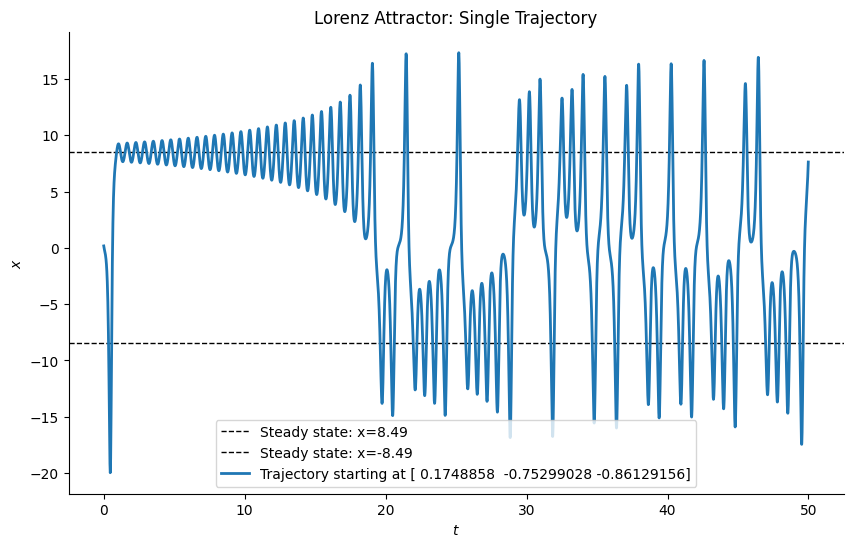

In [2]:
def lorenz(xyz, t, sigma, rho, beta):
    x, y, z = xyz  # parse variables
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]


sigma = 10.0
beta = 8 / 3
rho = 28.0

T = 50.0  # total time to run
dt = 0.01  # time step
time_points = np.arange(0.0, T, dt)

# Nontrivial steady state values for plotting
x2 = y2 = np.sqrt(beta * (rho - 1))  # nontrivial steady state
z2 = rho - 1

init = np.random.rand(3) * 2 - 1  # initial conditions between -1 and 1
sol2 = odeint(lorenz, init, time_points, args=(sigma, rho, beta))

plt.figure(figsize=(10, 6))
# Plot nontrivial steady states as horizontal lines
plt.axhline(x2, color="k", lw=1, linestyle="--", label=f"Steady state: x={x2:.2f}")
plt.axhline(-x2, color="k", lw=1, linestyle="--", label=f"Steady state: x={-x2:.2f}")

# Plot the single trajectory
plt.plot(time_points, sol2[:, 0], lw=2, label=f"Trajectory starting at {init}")

plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.title("Lorenz Attractor: Single Trajectory")
plt.legend()
plt.show()

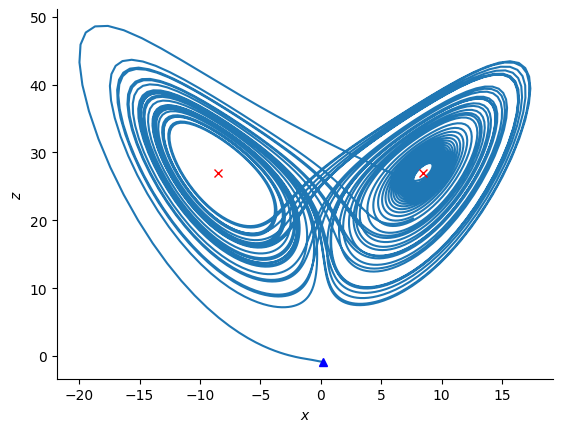

In [3]:
plt.figure()
plt.plot(sol2[:, 0], sol2[:, 2])  # plot trajectories projected onto the (x,z) plane
plt.plot(
    [sol2[0, 0]], [sol2[0, 2]], "b^"
)  # blue trianble labels starting point of each trajectory
plt.plot([x2], [z2], "rx")  # steady state
plt.plot([-x2], [z2], "rx")  # steady state
plt.xlabel(r"$x$")
plt.ylabel(r"$z$")
plt.show()

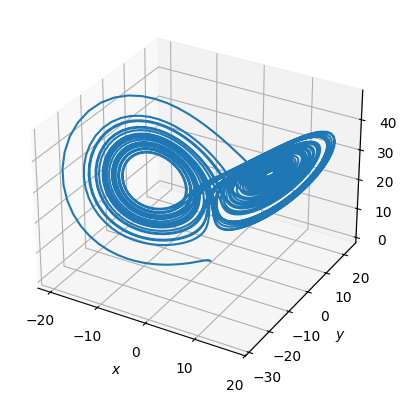

In [4]:
# Let us now visualize all the solutions as trajectories in a 3-d plot

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(sol2[:, 0], sol2[:, 1], sol2[:, 2])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_zlabel(r"$z$")
plt.show()

The bifurcation diagram shows the possible steady states or periodic orbits of the system for different values of a system parameter (like $\rho$). This is a compact and powerful way to visualize how small changes in a parameter can drastically alter the system's behavior.

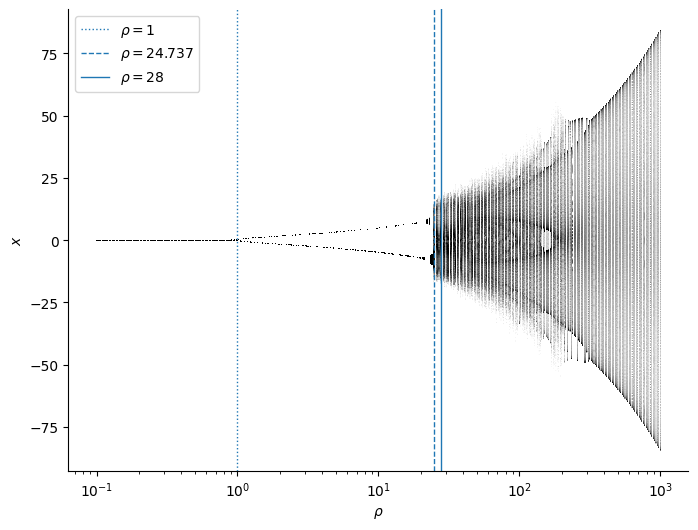

In [5]:
sigma = 10.0
beta = 8 / 3.0

t1 = 20.0  # time to add perturbation
T = 100.0
dt = 0.01
time_points = np.arange(0.0, 50.0, 0.01)

rho_list = np.geomspace(0.1, 1000.0, 401)  # list of rho values geometrically spaced
sol_list = []  # list of solutions of Lorenz equations

for rho in rho_list:
    init = np.random.rand(3) * 2 - 1  # random initial values
    sol = odeint(lorenz, init, time_points, args=(sigma, rho, beta))
    sol_list.append(sol)


rP = 1  # onset of instability at the origin, pitchfork bifurcation
rH = sigma * (sigma + beta + 3) / (sigma - beta - 1)  # onset of chaos, Hopf bifurcation

plt.figure(figsize=(8, 6))
plt.axvline(rP, lw=1, ls=":", label=r"$\rho = 1$")
plt.axvline(rH, lw=1, ls="--", label=r"$\rho = %.3f$" % rH)
plt.axvline(28, lw=1, ls="-", label=r"$\rho = 28$")
for i in range(len(rho_list)):
    rho = rho_list[i]
    sol = sol_list[i]
    y = sol[int(t1 / dt) :, 0]
    x = [rho] * len(y)
    plt.scatter(x, y, s=0.1, c="k", marker=".", edgecolor="none")

plt.xscale("log")
plt.xlabel(r"$\rho$")
plt.ylabel(r"$x$")
plt.legend()
plt.show()

The stable steady state at the origin undergoes a **pitchfork bifurcation**, splitting into two distinct steady states. As the parameter increases further, these two steady states experience a **Hopf bifurcation**, where one of the fixed points becomes a saddle point, marking the onset of chaotic behavior. For \(\rho < 24.74\), the system exhibits steady states or periodic orbits, while for \(\rho \geq 24.74\), chaos emerges, revealing a fractal structure.

## Modeling with SysIdentPy

Let's visualize the data that we need to model

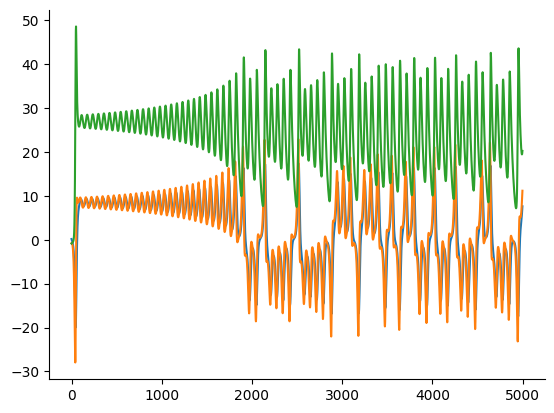

In [6]:
plt.plot(sol2)

c:\Users\wilso\miniconda3\envs\sysidentpyv04\Lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:621: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 10
  self.info_values = self.information_criterion(reg_matrix, y)


       Regressors   Parameters             ERR
0          y(k-1)   9.1832E-01  9.98019711E-01
1         x1(k-1)   9.4946E-02  1.97448493E-03
2   x2(k-1)y(k-1)  -4.7263E-04  5.79130765E-06
3  x2(k-1)x1(k-1)  -2.1239E-05  4.72613968E-09
4         x2(k-1)   6.9084E-06  4.82674757E-10
5       x1(k-1)^2  -1.1524E-06  4.27141670E-11
6        y(k-1)^2  -8.8057E-06  3.31043247E-11
7               1  -1.8509E-04  3.67821804E-11
8   x1(k-1)y(k-1)   7.9252E-06  5.31217490E-11
9       x2(k-1)^2   5.5901E-07  5.27580418E-12


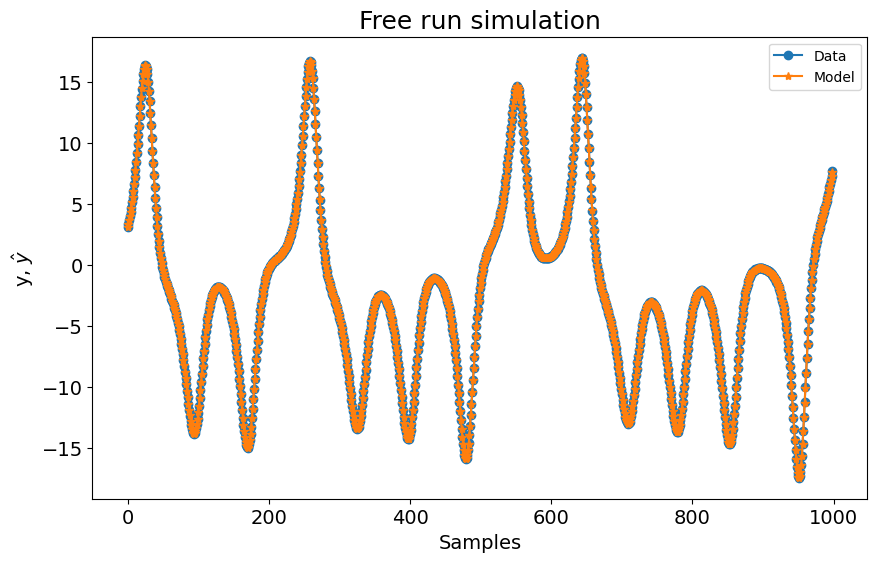

       Regressors   Parameters             ERR
0          y(k-1)   9.9829E-01  9.96084591E-01
1   x2(k-1)y(k-1)  -6.5230E-04  3.09653629E-03
2  x2(k-1)x1(k-1)  -9.6452E-03  4.62214305E-04
3         x1(k-1)   2.7760E-01  3.50549821E-04
4         x2(k-1)   2.8138E-04  3.86911341E-07
5        y(k-1)^2  -3.2352E-05  3.41517241E-08
6       x1(k-1)^2  -2.6343E-04  2.79943269E-08
7               1  -6.2559E-03  3.02963912E-08
8   x1(k-1)y(k-1)   2.3472E-04  4.11556688E-08
9       x2(k-1)^2   1.5355E-05  3.32074748E-09


c:\Users\wilso\miniconda3\envs\sysidentpyv04\Lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:621: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 10
  self.info_values = self.information_criterion(reg_matrix, y)


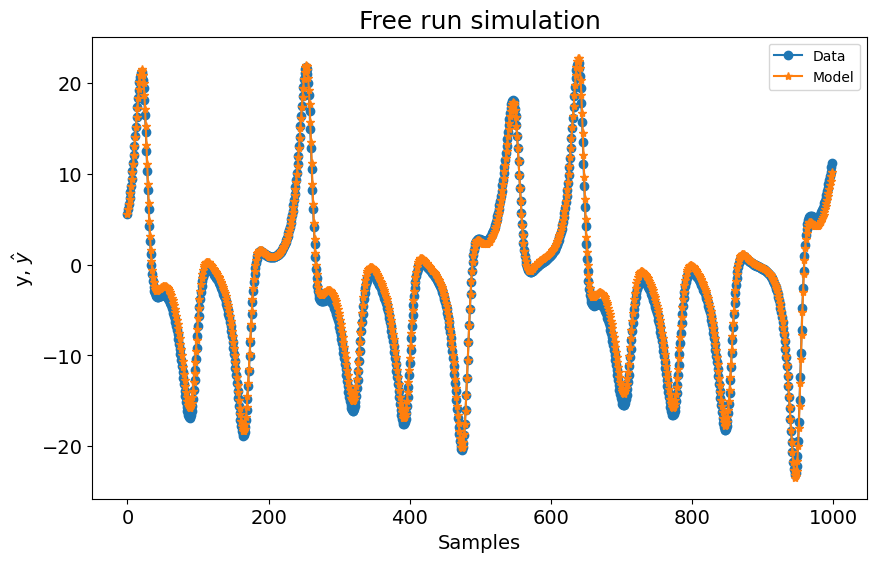

c:\Users\wilso\miniconda3\envs\sysidentpyv04\Lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:621: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 10
  self.info_values = self.information_criterion(reg_matrix, y)


       Regressors   Parameters             ERR
0          y(k-1)   9.7932E-01  9.99326652E-01
1  x2(k-1)x1(k-1)   8.7471E-03  6.70396643E-04
2       x2(k-1)^2   9.5637E-04  2.13515631E-06
3       x1(k-1)^2  -1.1022E-04  4.45532422E-07
4         x1(k-1)   4.1767E-03  3.37917913E-08
5        y(k-1)^2  -1.5200E-04  1.35172660E-08
6               1  -3.4932E-02  2.45525697E-08
7         x2(k-1)  -2.9565E-03  1.41491234E-09
8   x2(k-1)y(k-1)   8.8849E-05  3.12544165E-09
9   x1(k-1)y(k-1)  -1.0276E-04  6.02297621E-09


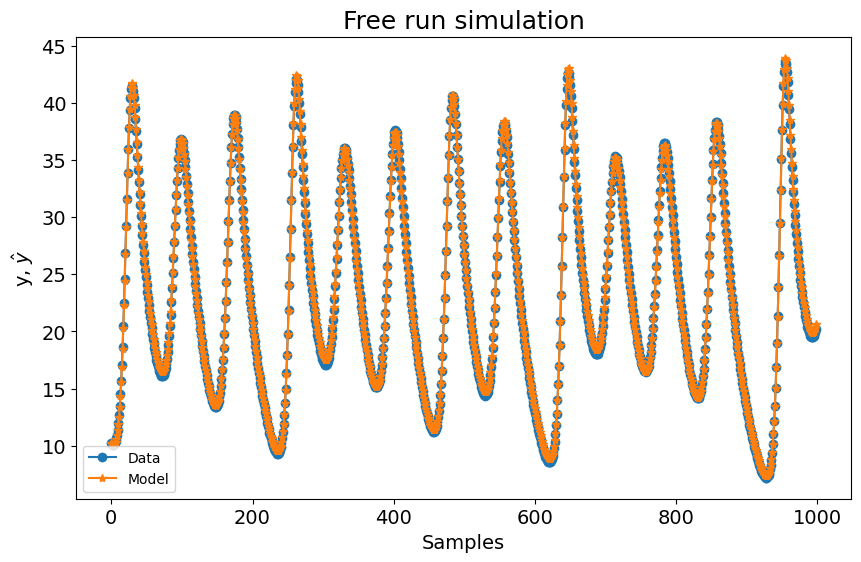

In [7]:
def prepare_data(data, y_col, x_cols, train_size=4000):
    """Split and reshape the data for each model."""
    train_data, test_data = data[:train_size], data[train_size:]

    # Extract y (target) and x (predictors)
    y_train, y_test = train_data[:, y_col].reshape(-1, 1), test_data[:, y_col].reshape(
        -1, 1
    )
    x_train, x_test = train_data[:, x_cols], test_data[:, x_cols]

    return x_train, y_train, x_test, y_test


def train_and_predict(x_train, y_train, x_test, y_test):
    """Train the model and make predictions."""
    basis_function = Polynomial(degree=2)
    model = FROLS(
        ylag=1,
        xlag=[[1], [1]],
        estimator=LeastSquares(),
        basis_function=basis_function,
    )
    model.fit(X=x_train, y=y_train)
    yhat = model.predict(
        X=x_test,
        y=y_test[: model.max_lag].reshape(-1, 1),
    )

    r = pd.DataFrame(
        results(
            model.final_model,
            model.theta,
            model.err,
            model.n_terms,
            err_precision=8,
            dtype="sci",
        ),
        columns=["Regressors", "Parameters", "ERR"],
    )
    print(r)
    return yhat


# First model: Using sol2[:, 0] for y and sol2[:, [1, 2]] for x
x_train, y_train, x_test, y_test = prepare_data(
    sol2, y_col=0, x_cols=[1, 2], train_size=4000
)
yhat_1 = train_and_predict(x_train, y_train, x_test, y_test)

# set 1 because is the maximum lag. Can set as model.max_lag as well
plot_results(y=y_test[1:], yhat=yhat_1[1:], n=1000)

# Second model: Using sol2[:, 1] for y and sol2[:, [0, 2]] for x
x_train, y_train, x_test, y_test = prepare_data(
    sol2, y_col=1, x_cols=[0, 2], train_size=4000
)
yhat_2 = train_and_predict(x_train, y_train, x_test, y_test)

plot_results(y=y_test[1:], yhat=yhat_2[1:], n=1000)

# Third model: Using sol2[:, 2] for y and sol2[:, [0, 1]] for x
x_train, y_train, x_test, y_test = prepare_data(
    sol2, y_col=2, x_cols=[0, 1], train_size=4000
)
yhat_3 = train_and_predict(x_train, y_train, x_test, y_test)

plot_results(y=y_test[1:], yhat=yhat_3[1:], n=1000)

## Results

Now we can visualize the results of each predicted trajectory

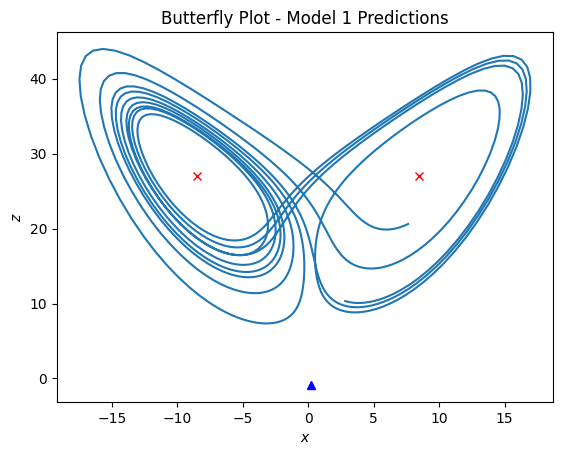

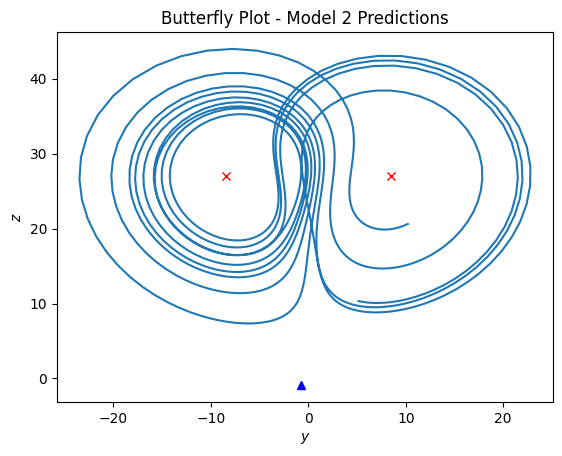

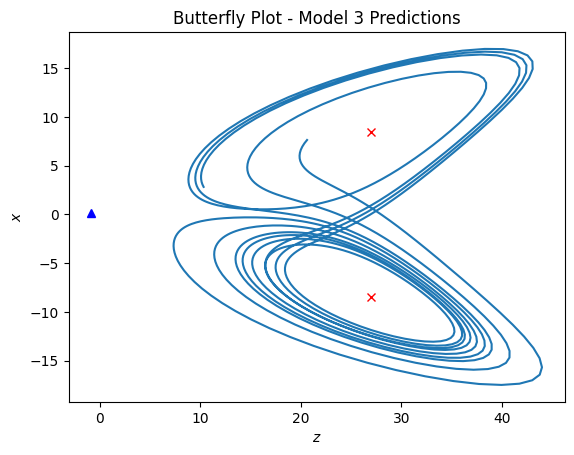

In [8]:
# First model: Using predictions from yhat_1 (predicted x vs predicted z)
plt.figure()
plt.plot(yhat_1, yhat_3)  # plot predictions projected onto the (x, z) plane
plt.plot(
    [sol2[0, 0]], [sol2[0, 2]], "b^"
)  # blue triangle labels starting point of each trajectory
plt.plot([x2], [z2], "rx")  # steady state
plt.plot([-x2], [z2], "rx")  # steady state
plt.xlabel(r"$x$")
plt.ylabel(r"$z$")
plt.title("Butterfly Plot - Model 1 Predictions")
plt.show()

# Second model: Using predictions from yhat_2 (predicted y vs predicted z)
plt.figure()
plt.plot(yhat_2, yhat_3)  # plot predictions projected onto the (y, z) plane
plt.plot(
    [sol2[0, 1]], [sol2[0, 2]], "b^"
)  # blue triangle labels starting point of each trajectory
plt.plot([x2], [z2], "rx")  # steady state
plt.plot([-x2], [z2], "rx")  # steady state
plt.xlabel(r"$y$")
plt.ylabel(r"$z$")
plt.title("Butterfly Plot - Model 2 Predictions")
plt.show()

# Third model: Using predictions from yhat_3 (predicted z vs predicted x)
plt.figure()
plt.plot(yhat_3, yhat_1)  # plot predictions projected onto the (z, x) plane
plt.plot(
    [sol2[0, 2]], [sol2[0, 0]], "b^"
)  # blue triangle labels starting point of each trajectory
plt.plot([z2], [x2], "rx")  # steady state
plt.plot([z2], [-x2], "rx")  # steady state
plt.xlabel(r"$z$")
plt.ylabel(r"$x$")
plt.title("Butterfly Plot - Model 3 Predictions")
plt.show()

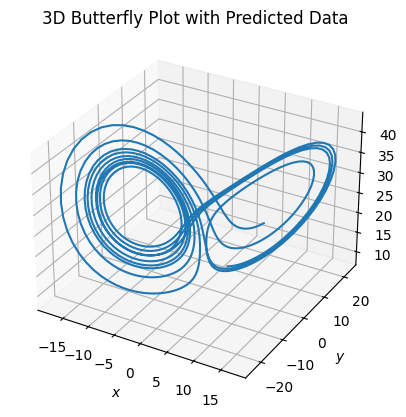

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(yhat_1, yhat_2, yhat_3)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_zlabel(r"$z$")
ax.set_title("3D Butterfly Plot with Predicted Data")
plt.show()


As shown in the plots above, the models effectively capture the dynamics of the Lorenz system, reproducing the stable cycles in periodic regimes with minimal prediction errors. In chaotic regimes, the models maintain accurate short-term predictions but can exhibit long-term divergence, which is expected due to the sensitivity to initial conditions intrinsic to chaotic systems. Although finer details may require more sophisticated model configurations, SysIdentPy demonstrates its capability to model the nonlinear dynamics of the Lorenz system, even in the chaotic regime. This experiment highlights SysIdentPy's versatility in capturing both stable and chaotic behaviors in complex systems.